In [1]:
%matplotlib notebook

In [24]:
import numpy as np
from facenet_models import FacenetModel
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import text
import skimage.io as io
from PIL import Image
import cv2 as cv
import glob

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

if (torch.cuda.is_available()):
    print("GPU available")

GPU available


In [12]:
def find_eyes(image_data, *, box_threshold=0.97, prop_const=0.13):
    """
    Displays an image with boxes around people's faces and labels them with names.
    Parameters
    ----------
    image_data : numpy.ndarray, shape-(R, C, 3) (RGB is the last dimension)
        Pixel information for the image.
    """
    model = FacenetModel()
    boxes, probabilities, landmarks = model.detect(image_data)
    face_detected = True

    
    if (boxes is None):
        face_detected = False
        return [], [], face_detected
    
    fig, ax = plt.subplots()
    ax.imshow(image_data)
    
    descriptors = model.compute_descriptors(image_data, boxes)
    
    eye_coords = []
    eye_boxes = []
    
    for box, prob, landmark in zip(boxes, probabilities, landmarks):
        if prob<box_threshold:
            continue
        lefteye = landmark[0]
        righteye = landmark[1]
        
              
        width_radius = ((box[3] - box[1]) + (box[2] - box[0]))/2 * prop_const
        height_radius = width_radius / 2
        
        # boxes in form [left,top,right,bottom]
        leftBox = [lefteye[0] - width_radius, 
                   lefteye[1] + height_radius, 
                   lefteye[0] + width_radius,
                   lefteye[1] - height_radius]
        rightBox = [righteye[0] - width_radius, 
                    righteye[1] + height_radius, 
                    righteye[0] + width_radius,
                    righteye[1] - height_radius]
        
        leftBox = np.array(leftBox)
        rightBox = np.array(rightBox)
        
        #ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), fill=None, lw=2, color="red"))
        ax.add_patch(Rectangle(leftBox[:2], *(leftBox[2:] - leftBox[:2]), fill=None, lw=2, color="yellow"))
        ax.add_patch(Rectangle(rightBox[:2], *(rightBox[2:] - rightBox[:2]), fill=None, lw=2, color="yellow"))
        
        for i in range(2):
            ax.plot(landmark[i, 0], landmark[i, 1], "+", color="blue")
        
    return leftBox, rightBox, face_detected

Filepath: alan1.png


<IPython.core.display.Javascript object>


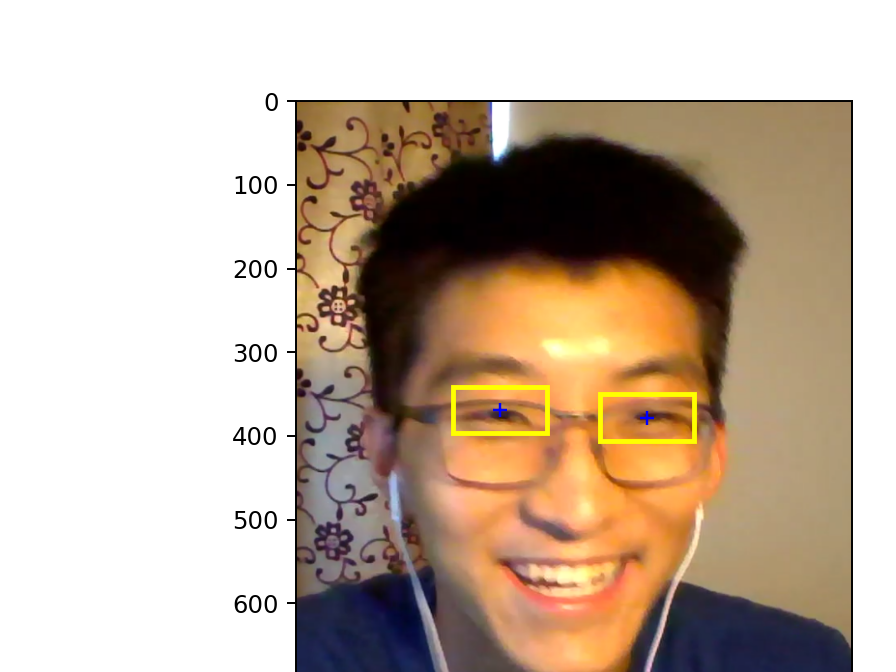

In [20]:
filepath = input("Filepath: ")
# pic = np.array(Image.open(filepath))[:,:,:3]
# shape-(Height, Width, Color)
pic = io.imread(str(filepath))
if pic.shape[-1] == 4:
    # Image is RGBA, where A is alpha -> transparency
    # Must make image RGB.
    pic = pic[..., :-1]  # png -> RGB
i = 0
face_detected = False
while (not face_detected and i < 4):
    leftBox, rightBox, face_detected = find_eyes(pic)
    pic = cv.rotate(pic, cv.ROTATE_90_CLOCKWISE)
    i += 1

In [38]:
cuda = torch.device('cuda')
print(type(cuda))

<class 'torch.device'>


In [32]:
class EyeModel(nn.Module):
    def __init__(self):
        super().__init__()
        # assumes 32x32
        self.conv1 = nn.Conv2d(1, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 48, 3)
        self.fc1 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.softmax(self.fc1(x))
        return x
model = EyeModel().to(cuda)
next(model.parameters()).is_cuda

True

In [102]:
class CustomImageDataset(Dataset):
    def __init__(self, numpydata, numpylabels, transform=None, target_transform=None):
        self.img_labels = numpylabels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels[idx]
        image = numpydata[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [86]:
closed_x = np.empty((1,24,24), dtype=int)
open_x = np.empty((1,24,24), dtype=int)

for filename in glob.glob('train_dataset/closedLeftEyes/*.*'):
    img = cv.imread(filename, 0)
    closed_x = np.concatenate((closed_x, np.array([img])))
    # 	closed_x.append(img)
    
for filename in glob.glob('train_dataset/closedRightEyes/*.*'):
    img = cv.imread(filename, 0)
    closed_x = np.concatenate((closed_x, np.array([img])))
    # 	closed_x.append(img)

for filename in glob.glob('train_dataset/openLeftEyes/*.*'):
    img = cv.imread(filename, 0)
    open_x = np.concatenate((open_x, np.array([img])))
    # 	open_x.append(img)

for filename in glob.glob('train_dataset/openRightEyes/*.*'):
    img = cv.imread(filename, 0)
    open_x = np.concatenate((open_x, np.array([img])))
    # 	open_x.append(img)
# closed_x = np.array(closed_x)
# open_x = np.array(open_x)
closed_x = closed_x[1:]
open_x = open_x[1:]

In [87]:
print(type(img[0,0]))

<class 'numpy.uint8'>


In [91]:
train_x = np.vstack((closed_x[:int(len(closed_x)*0.8)], open_x[:int(len(open_x)*0.8)]))
valid_x = np.vstack((closed_x[int(len(closed_x)*0.8):], open_x[int(len(open_x)*0.8):]))

train_y = [0 for i in range(int(len(closed_x)*0.8))] + [1 for i in range(int(len(open_x)*0.8))]
valid_y = [0 for i in range(len(closed_x) - int(len(closed_x)*0.8))] + [1 for i in range(len(open_x) - int(len(open_x)*0.8))]

train_x = torch.tensor(train_x, device=cuda)
valid_x = torch.tensor(valid_x, device=cuda)

train_y = torch.tensor(train_y, device=cuda)
valid_y = torch.tensor(valid_y, device=cuda)

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
batch_size = 32

data = CustomImageDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: DataLoader worker (pid(s) 103888, 75984) exited unexpectedly

In [96]:
epochs = 10
batch_size = 32

for iteration in range(0, epochs):
    indices = np.arange(len(train_x))
    np.random.shuffle(indices)
    
    # trains the model by improving the loss and accuracy metrics for the training data in batches
    for batch_count in range(0, len(train_x)//batch_size):
        batch_indices = indices[batch_count * batch_size : (batch_count+1) * batch_size]
        inputs = train_x[batch_indices]
        labels = train_y[batch_indices]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (batch_count) % 10 == 9:
            print(f'TRAINING loss is {loss}')
        

    # creates a shuffled array of testing indices  
    test_indices = np.arange(len(valid_x))
    np.random.shuffle(test_indices)
    
    for batch_count in range(0, len(valid_x)//batch_size):
        test_batch_indices = test_indices[batch_count * batch_size : (batch_count+1) * batch_size]
        inputs = test_x[test_batch_indices]
        labels = test_y[test_batch_indices]

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        if (batch_count) % 10 == 9:
            print(f'TESTING loss is {loss}')

RuntimeError: Given groups=1, weight of size [24, 1, 3, 3], expected input[1, 32, 24, 24] to have 1 channels, but got 32 channels instead